In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import numpy as np
import pandas as pd

In [2]:
import mlflow
from mlflow.models import infer_signature

import os
import math
import seaborn as sns
from tqdm.notebook import tqdm, trange

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LOOKBACK = 5
HORIZON = 1

LEARNING_RATE = 0.1
BATCH_SIZE = 64
NUM_EPOCHS = 50
LR_DECAY = 0.1
PATIENCE = 3
MIN_DELTA = 1e-6

HIDDEN_SIZE = 32
NUM_LAYERS = 2
DROPOUT = 0

In [4]:
sns.set_theme('paper', rc={'figure.figsize': (16, 4)})

torch.manual_seed(42)

mlflow.set_experiment("Stock Market Predictions")
mlflow.start_run(run_name="LSTM")

<ActiveRun: >

In [5]:
DATA_FILE = 'SSEC.csv'
df = pd.read_csv(f'../data/{DATA_FILE}', index_col='Date')
data = df['Close'].values

mlflow.log_param("Dataset", DATA_FILE)

'SSEC.csv'

In [6]:
train_size = int(0.7*len(data))
val_size = int(0.15*len(data))
test_size = len(data) - train_size - val_size

mlflow.log_param("Train Size", train_size)
mlflow.log_param("Validation Size", val_size)
mlflow.log_param("Test Size", test_size)

data_train, data_val, data_test = data[:train_size], data[train_size:train_size+val_size], data[train_size+val_size:]

In [7]:
data_train.shape, data_val.shape, data_test.shape

((2382,), (510,), (511,))

In [8]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))

data_train = torch.FloatTensor(scaler.fit_transform(data_train.reshape(-1, 1))).to(DEVICE)
data_val = torch.FloatTensor(scaler.transform(data_val.reshape(-1, 1))).to(DEVICE)
data_test = torch.FloatTensor(scaler.transform(data_test.reshape(-1, 1))).to(DEVICE)

In [9]:
data_train.size(), data_val.size(), data_test.size()

(torch.Size([2382, 1]), torch.Size([510, 1]), torch.Size([511, 1]))

In [10]:
X_train = data_train.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_train = data_train[LOOKBACK:]

X_val = data_val.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_val = data_val[LOOKBACK:]

X_test = data_test.unfold(dimension=0, size=LOOKBACK, step=1)[:-1]
y_test = data_test[LOOKBACK:]

In [11]:
# (N,L,H_in​) 
X_train.size(), y_train.size(), X_val.size(), y_val.size(), X_test.size(), y_test.size()

(torch.Size([2377, 1, 5]),
 torch.Size([2377, 1]),
 torch.Size([505, 1, 5]),
 torch.Size([505, 1]),
 torch.Size([506, 1, 5]),
 torch.Size([506, 1]))

In [12]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=1, num_layers=1, output_size=1, dropout=0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [14]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [15]:
model = LSTMModel(LOOKBACK, HIDDEN_SIZE, NUM_LAYERS, HORIZON, DROPOUT)
criterion = nn.MSELoss()

model.to(DEVICE)
criterion.to(DEVICE)

MSELoss()

In [16]:
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=PATIENCE)
early_stopper = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)

In [17]:
params = {
    "Lookback": LOOKBACK,
    "Horizon": HORIZON,
    "Objective": type(criterion).__name__,
    "Optimizer": type(optimizer).__name__,
    "Scaler": type(scaler).__name__,
    "Scheduler": type(scheduler).__name__,
    "Num epochs": NUM_EPOCHS,
    "Batch size": BATCH_SIZE,
    "Learning rate": LEARNING_RATE,
    "Patience": PATIENCE,
    "LR Decay": LR_DECAY,
    "Early stopper min delta": MIN_DELTA,
    "Input size": LOOKBACK,
    "Hidden size": HIDDEN_SIZE,
    "Num layers": NUM_LAYERS,
    "Dropout": DROPOUT
}

mlflow.log_params(params)

In [18]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler, num_epochs: int):
    train_losses = []
    val_losses = []

    for epoch in (out_pbar:=trange(NUM_EPOCHS, unit='epoch')):
        out_pbar.set_description(f'Epoch:{epoch+1}/{NUM_EPOCHS} Best Validation Metric: {early_stopper.min_validation_loss:.5f}\r', refresh=True)
 
        # Training        
        model.train()
        epoch_train_loss = 0.0
        with tqdm(total=len(train_loader), unit='batch', leave=False) as pbar:
            for X, y in train_loader:
                pbar.update()
                    
                output = model(X_train)
                
                loss = criterion(output, y_train)
                loss.backward()
                            
                optimizer.step()
                optimizer.zero_grad()
                
                epoch_train_loss += loss.item()               
                pbar.set_description(f"Current training loss: {loss.item():.5f}", refresh=True)
        
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)
        mlflow.log_metric("train loss", epoch_train_loss, step=epoch+1)
        scheduler.step(loss)
        
        # Validation
        model.eval()
        epoch_val_loss = 0.0
        with tqdm(total=len(val_loader), unit='batch', leave=((epoch+1) % (num_epochs/20) == 0)) as pbar, torch.no_grad():
            for X, y in val_loader:
                pbar.update()
                                        
                output = model(X)
                loss = criterion(output, y)
                
                epoch_val_loss += loss.item()
                pbar.set_description(f"Current validation loss: {loss.item():.5f}", refresh=True)
            
            epoch_val_loss /= len(val_loader)
            val_losses.append(epoch_val_loss)
            pbar.set_description(f"Epoch: {epoch+1}, Total validation loss: {epoch_val_loss:.5f}", refresh=True)
            mlflow.log_metric("val loss", epoch_val_loss, step=epoch+1)
            
            if epoch_val_loss < early_stopper.min_validation_loss:                  
                mlflow.log_metric("best val loss", early_stopper.min_validation_loss)                 
                torch.save(model.state_dict(), f'../models/{type(model).__name__}.pt')
                
            if early_stopper(epoch_val_loss):
                print(f"Early stopping at epoch {epoch+1}")
                mlflow.log_metric("early stop epoch", epoch+1)
                break

    return train_losses, val_losses

In [19]:
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/8 [00:00<?, ?batch/s]

Early stopping at epoch 15


<Axes: >

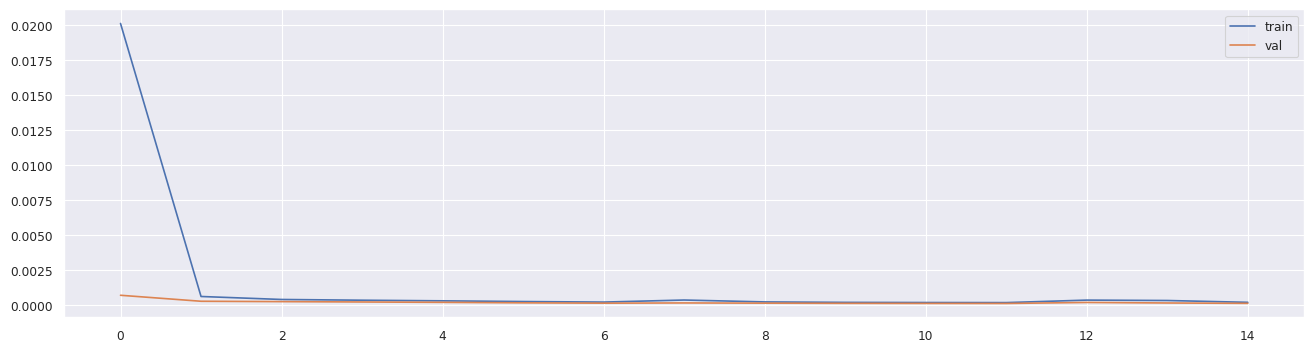

In [20]:
sns.lineplot(data=pd.DataFrame(data={'train': train_losses[::len(train_losses)//len(val_losses)], 'val': val_losses}), dashes=False)

In [21]:
if os.path.exists(f'../models/{type(model).__name__}.pt'):    
    model.load_state_dict(torch.load(f"../models/{type(model).__name__}.pt"))
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

y_pred_inv = scaler.inverse_transform(y_pred.cpu().detach().numpy()).flatten()
y_test_inv = scaler.inverse_transform(y_test.cpu().detach().numpy()).flatten()

mlflow.pytorch.log_model(
    registered_model_name="LSTM",
    artifact_path="LSTM",
    pytorch_model=model,
    input_example = X_test.cpu().detach().numpy(),
    signature=infer_signature(X_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
)

Registered model 'LSTM' already exists. Creating a new version of this model...
2025/02/24 20:54:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LSTM, version 30
Created version '30' of model 'LSTM'.


<Axes: xlabel='Date'>

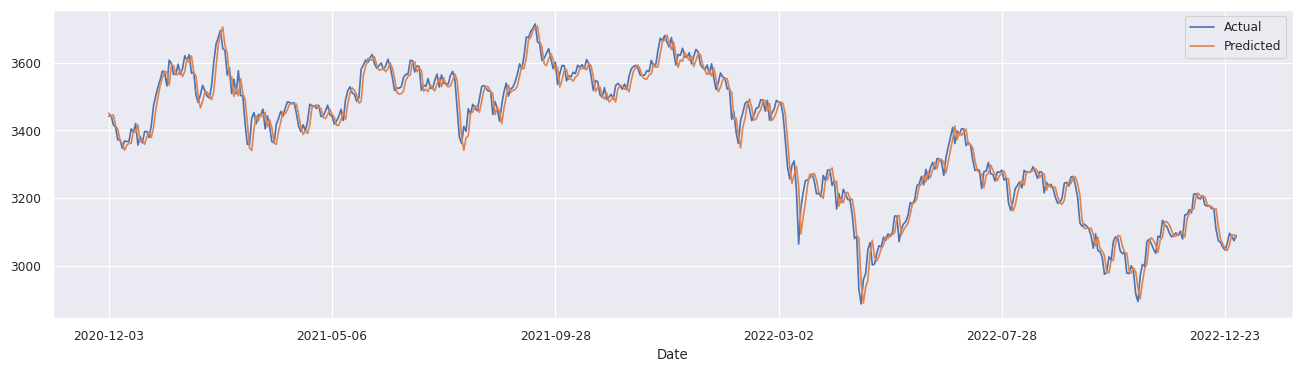

In [22]:
pd.DataFrame([y_test_inv, y_pred_inv], index=['Actual', 'Predicted'], columns=df.index[-len(X_test):]).T.plot()

In [23]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(y_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_pred_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric("Test MAE", mae)
mlflow.log_metric("Test MSE", mse)
mlflow.log_metric("Test RMSE", rmse)

print(f"Test MAE: {mae:.4f}  Test MSE: {mse:.4f} Test RMSE: {rmse:.4f}")

Test MAE: 26.2929  Test MSE: 1180.4709 Test RMSE: 34.3580


In [24]:
model.eval()
y_recursive = []

# Start with the first element of X_test
current_input = X_test[0].unsqueeze(0)

with torch.no_grad():
    for _ in range(len(X_test)):
        output = model(current_input).unsqueeze(0)
        y_recursive.append(output.cpu().numpy())

        # Prepare the next input by appending the prediction to the current input and removing the oldest value
        current_input = torch.cat((current_input[:, :, 1:], output), dim=2)

y_recursive = np.concatenate(y_recursive, axis=1).squeeze()
y_recursive_inv = scaler.inverse_transform(y_recursive.reshape(-1, 1)).flatten()

<Axes: xlabel='Date'>

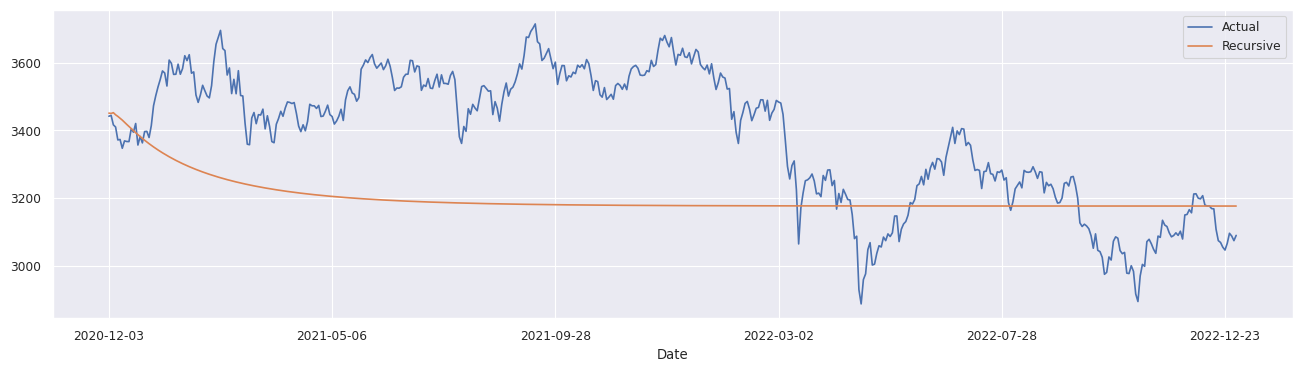

In [25]:
pd.DataFrame([y_test_inv, y_recursive_inv], index=['Actual', 'Recursive'], columns=df.index[-len(X_test):]).T.plot()

In [26]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_recursive_inv, y_test_inv)
mse = metrics.mean_squared_error(y_recursive_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_recursive_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric("Recursive Test MAE", mae)
mlflow.log_metric("Recursive Test MSE", mse)
mlflow.log_metric("Recursive Test RMSE", rmse)
mlflow.end_run()

print(f"Recursive MAE: {mae:.4f} Recursive MSE: {mse:.4f} Recursive RMSE: {rmse:.4f}")

🏃 View run LSTM at: http://172.18.0.2:5000/#/experiments/689077898730888678/runs/ad3c7558f4a94d5592af109dec4ecd0f
🧪 View experiment at: http://172.18.0.2:5000/#/experiments/689077898730888678
Recursive MAE: 224.2421 Recursive MSE: 70275.8438 Recursive RMSE: 265.0959


In [27]:
#Compare to the naive forecast
shifted_y_test_inv = np.roll(y_test_inv, 1).flatten()
shifted_y_test_inv[0] = y_test_inv[0]

<Axes: xlabel='Date'>

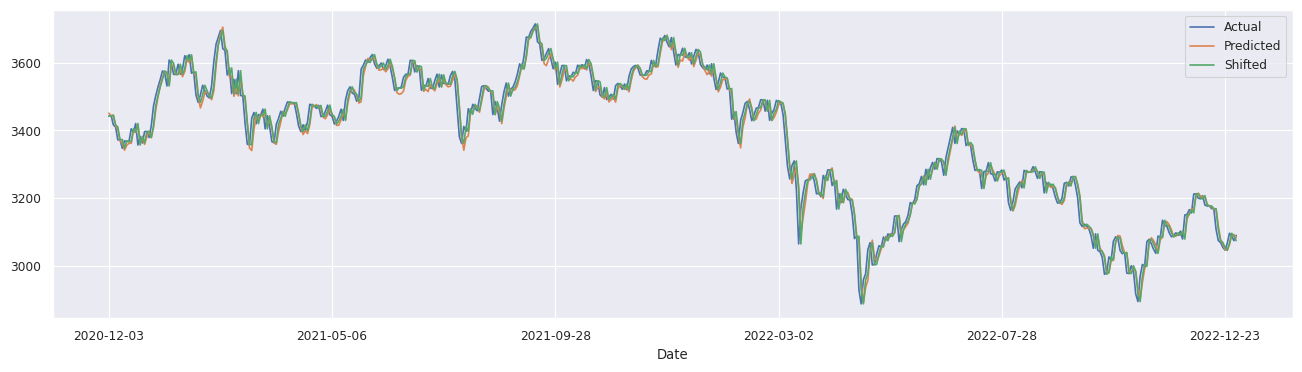

In [28]:
pd.DataFrame([y_test_inv, y_pred_inv, shifted_y_test_inv], index=['Actual', 'Predicted', 'Shifted'], columns=df.index[-len(X_test):]).T.plot()

In [29]:
# Naive predictions
mae = metrics.mean_absolute_error(shifted_y_test_inv, y_test_inv)
mse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv)
rmse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv) ** 0.5

print(f"Naive MAE: {mae:.4f}  Naive MSE: {mse:.4f} Naive RMSE: {rmse:.4f}")

Naive MAE: 24.9891  Naive MSE: 1112.6173 Naive RMSE: 33.3559


In [30]:
const_pred_inv = np.full_like(y_test_inv.flatten(), scaler.inverse_transform(X_test[0].cpu().numpy().flatten().reshape(-1, 1))[-1][0])

<Axes: xlabel='Date'>

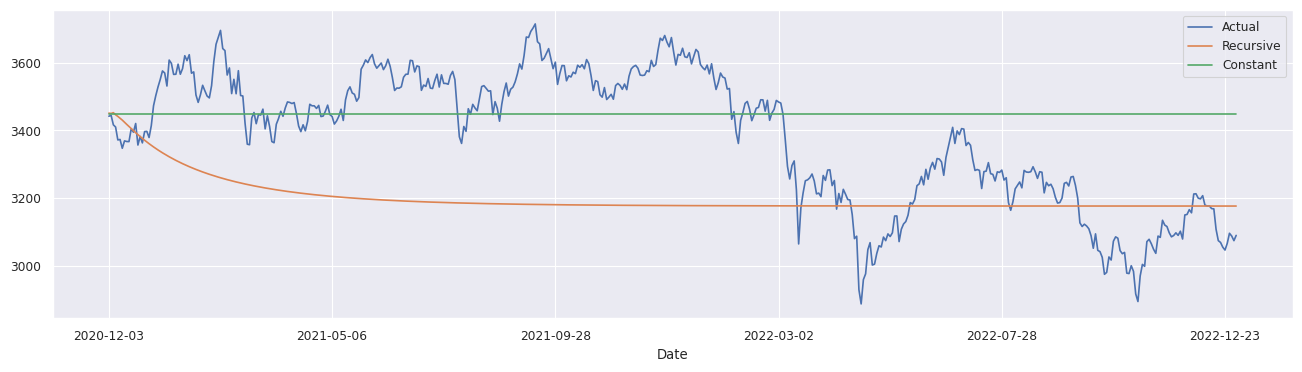

In [31]:
pd.DataFrame([y_test_inv, y_recursive_inv, const_pred_inv], index=['Actual', 'Recursive', 'Constant'], columns=df.index[-len(X_test):]).T.plot()

In [32]:
# Constant prediction
mae = metrics.mean_absolute_error(const_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(const_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(const_pred_inv, y_test_inv) ** 0.5

print(f"Constant MAE: {mae:.4f} Constant MSE: {mse:.4f} Constant RMSE: {rmse:.4f}")

Constant MAE: 165.6979 Constant MSE: 42911.6953 Constant RMSE: 207.1514


In [33]:
# Get predictions on the training dataset to check for overfitting
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)

y_train_pred_inv = scaler.inverse_transform(y_train_pred.cpu().detach().numpy()).flatten()
y_train_inv = scaler.inverse_transform(y_train.cpu().detach().numpy()).flatten()

<Axes: xlabel='Date'>

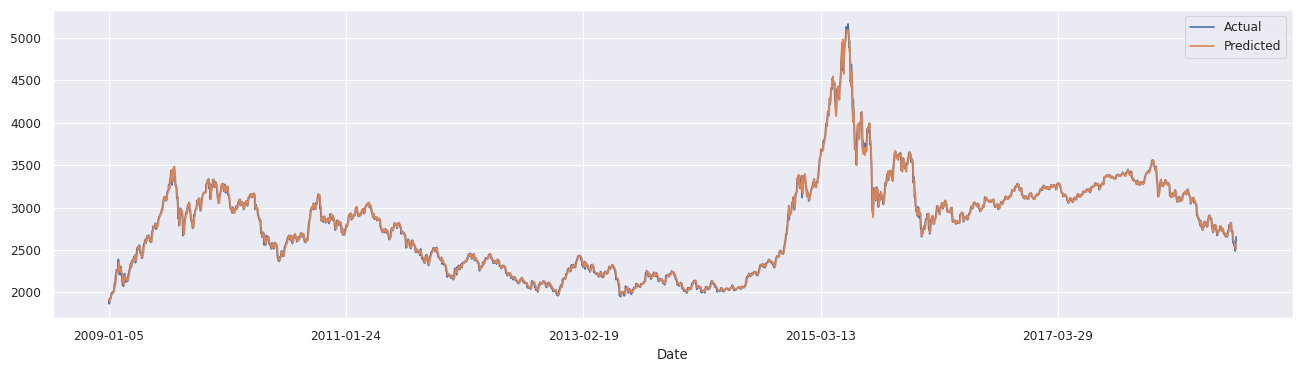

In [34]:
pd.DataFrame([y_train_inv, y_train_pred_inv], index=['Actual', 'Predicted'], columns=df.index[:len(X_train)]).T.plot()

In [35]:
# Evaluate the model on the training dataset
mae = metrics.mean_absolute_error(y_train_pred_inv, y_train_inv)
mse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv)
rmse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv) ** 0.5

print(f"Train MAE: {mae:.4f} Train MSE: {mse:.4f} Train RMSE: {rmse:.4f}")

Train MAE: 29.7343 Train MSE: 2094.2922 Train RMSE: 45.7634
